© Alexander Jüstel, Fraunhofer IEG, Institution for Energy Infrastructures and Geothermal Systems, RWTH Aachen University,
GNU Lesser General Public License v3.0

# 02 Processing Data Type 1 - Raster

This notebook illustrates how to process data of Data Type 1 - Raster. Even though the output raster will also be a raster, we need to make shure that the correct coordinate system and the correct origin is used. 

## Importing Libraries

In [1]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

from pyheatdemand import processing 

C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Loading Sample Data

The sample data is loaded using `rasterio`.

In [2]:
data = rasterio.open('../../../test/data/Data_Type_I_Raster.tif')
data

<open DatasetReader name='../../../test/data/Data_Type_I_Raster.tif' mode='r'>

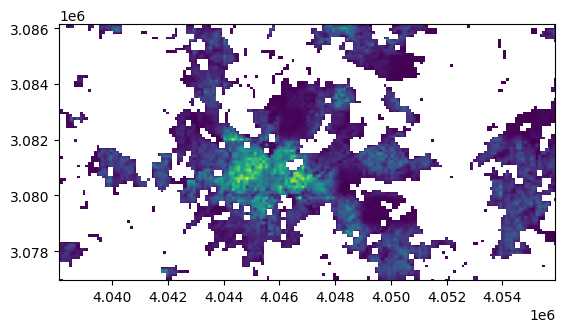

<Axes: >

In [3]:
show(data)

## Inspect CRS

We are inspecting the CRS and see that is does not match with the desired CRS `EPSG:3034`.

In [4]:
data.crs

CRS.from_epsg(3035)

## Vectorizing Raster Data

The raster data is vectorized for further processing. The result will be a `GeoDataFrame` containing the Heat Demand values in the column `class`.

In [5]:
raster_vectorized = processing.vectorize_raster('../../../test/data/Data_Type_I_Raster.tif')
raster_vectorized

,geometry,class
0,"POLYGON ((4038305.864 3086142.360, 4038305.864...",0.292106
1,"POLYGON ((4038405.844 3086142.360, 4038405.844...",41.289803
2,"POLYGON ((4038505.823 3086142.360, 4038505.823...",61.701653
3,"POLYGON ((4038605.803 3086142.360, 4038605.803...",148.921814
4,"POLYGON ((4038705.783 3086142.360, 4038705.783...",106.212265
...,...,...
8096,"POLYGON ((4052003.074 3077062.838, 4052003.074...",101.278137
8097,"POLYGON ((4052103.054 3077062.838, 4052103.054...",54.485630
8098,"POLYGON ((4052902.891 3077062.838, 4052902.891...",148.980194
8099,"POLYGON ((4053002.871 3077062.838, 4053002.871...",135.393631


Text(70.09722222222221, 0.5, 'Y [m]')

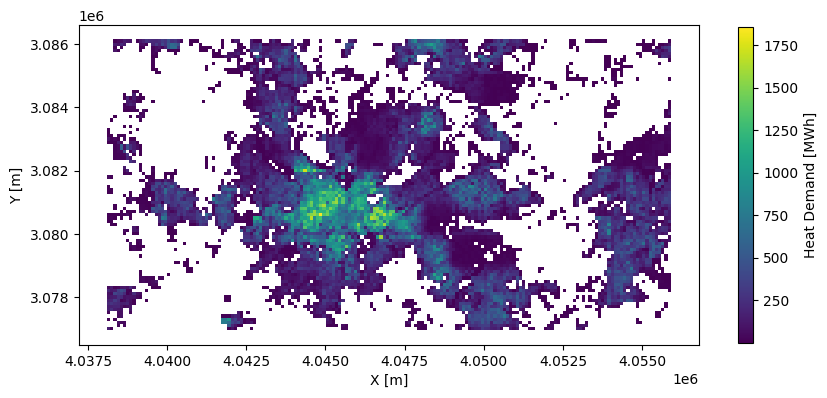

In [6]:
fig, ax = plt.subplots(1, figsize=(10,10))

raster_vectorized.plot(ax=ax, column='class', legend=True, legend_kwds={'shrink':0.41, 'label': 'Heat Demand [MWh]'})
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

## Reprojecting CRS

The CRS of the data is reprojected to the desired CRS `EPSG:3034`.

In [7]:
raster_vectorized = raster_vectorized.to_crs('EPSG:3034')

## Creating GeoDataFrame Outline from vectorized Raster

For further processing, we are creating an outline `GeoDataFrame` from the `total_bounds` of the vectorized raster.

In [8]:
gdf = processing.create_outline(raster_vectorized)
gdf

,geometry
0,"POLYGON ((3744005.190 2671457.082, 3744005.190..."


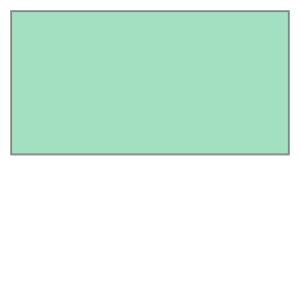

In [9]:
gdf.iloc[0].geometry

## Loading Interreg Mask

We are loading the previously created 10 km mask. 

In [10]:
mask_10km = gpd.read_file('../../../test/data/Interreg_NWE_mask_10km_3034.shp')
mask_10km

,FID,geometry
0,0,"POLYGON ((2651470.877 2955999.353, 2651470.877..."
1,1,"POLYGON ((2651470.877 2965999.353, 2651470.877..."
2,2,"POLYGON ((2651470.877 2975999.353, 2651470.877..."
3,3,"POLYGON ((2651470.877 2985999.353, 2651470.877..."
4,4,"POLYGON ((2651470.877 2995999.353, 2651470.877..."
...,...,...
9225,9225,"POLYGON ((4141470.877 2605999.353, 4141470.877..."
9226,9226,"POLYGON ((4141470.877 2615999.353, 4141470.877..."
9227,9227,"POLYGON ((4151470.877 2585999.353, 4151470.877..."
9228,9228,"POLYGON ((4151470.877 2595999.353, 4151470.877..."


In [11]:
mask_10km.crs

<Projected CRS: EPSG:3034>
Name: ETRS89-extended / LCC Europe
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Conformal 2001
- method: Lambert Conic Conformal (2SP)
Datum: Euro

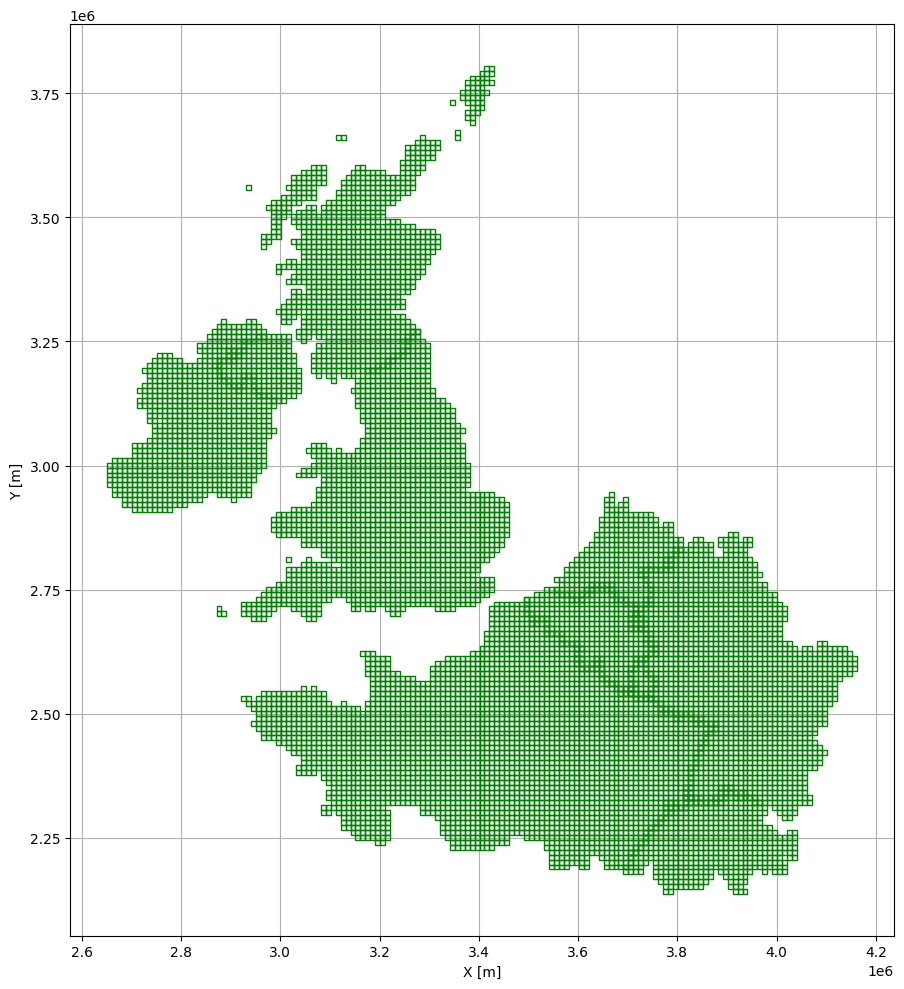

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
mask_10km.boundary.plot(ax=ax, linewidth=1, color='green')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()
plt.tight_layout()

## Crop Mask to Data Limits

The 10 km cells that intersect with the data outline are selected. 

In [13]:
mask_10km_cropped = mask_10km.sjoin(gdf).reset_index()[['geometry']]
mask_10km_cropped

,geometry
0,"POLYGON ((3721470.877 2665999.353, 3721470.877..."
1,"POLYGON ((3731470.877 2665999.353, 3731470.877..."
2,"POLYGON ((3721470.877 2665999.353, 3721470.877..."
3,"POLYGON ((3721470.877 2675999.353, 3721470.877..."
4,"POLYGON ((3731470.877 2675999.353, 3731470.877..."
5,"POLYGON ((3721470.877 2665999.353, 3721470.877..."
6,"POLYGON ((3721470.877 2675999.353, 3721470.877..."
7,"POLYGON ((3731470.877 2665999.353, 3731470.877..."
8,"POLYGON ((3731470.877 2675999.353, 3731470.877..."
9,"POLYGON ((3741470.877 2665999.353, 3741470.877..."


## Plotting the Cropped Mask

The cropped mask and the data outline are plotted using `matplotlib`. 

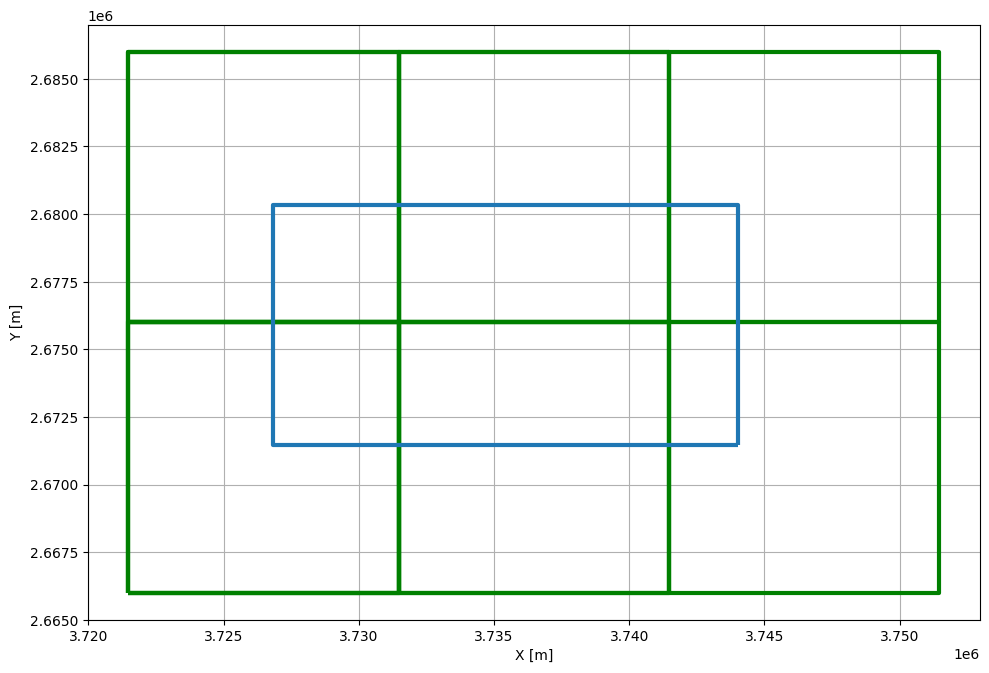

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
mask_10km_cropped.boundary.plot(ax=ax, linewidth=3, color='green')
gdf.to_crs('EPSG:3034').boundary.plot(ax=ax, linewidth=3)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()
plt.tight_layout()

## Creating mask from cropped mask

Here, the final mask with a width and height of 100 m is created. 

In [15]:
mask_100m_cropped = processing.create_polygon_mask(gdf=mask_10km_cropped, 
                                                   step_size=100,
                                                   crop_gdf=True)
mask_100m_cropped

,geometry
0,"POLYGON ((3721470.877 2665999.353, 3721570.877..."
1,"POLYGON ((3721470.877 2666099.353, 3721570.877..."
2,"POLYGON ((3721470.877 2666199.353, 3721570.877..."
3,"POLYGON ((3721470.877 2666299.353, 3721570.877..."
4,"POLYGON ((3721470.877 2666399.353, 3721570.877..."
...,...
112610,"POLYGON ((3751370.877 2685499.353, 3751470.877..."
112611,"POLYGON ((3751370.877 2685599.353, 3751470.877..."
112612,"POLYGON ((3751370.877 2685699.353, 3751470.877..."
112613,"POLYGON ((3751370.877 2685799.353, 3751470.877..."


## Cropping Mask to outline

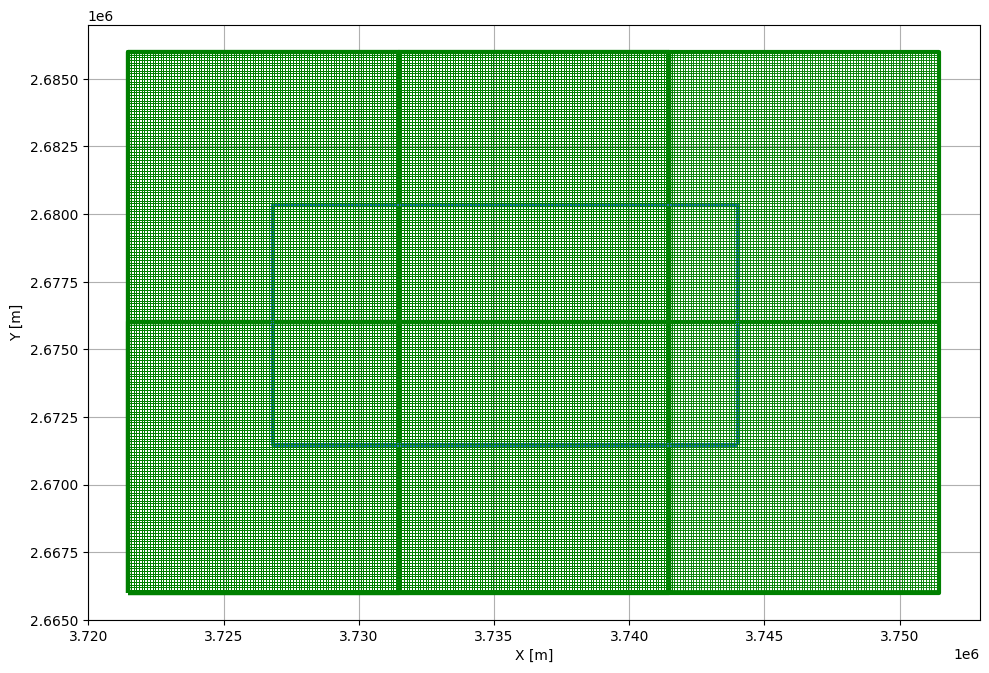

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
mask_10km_cropped.boundary.plot(ax=ax, linewidth=3, color='green')
gdf.to_crs('EPSG:3034').boundary.plot(ax=ax, linewidth=3)
mask_100m_cropped.boundary.plot(ax=ax, linewidth=0.5, color='green')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()
plt.tight_layout()

#plt.savefig('../images/Data_Type_1_Outline.png', dpi=300)

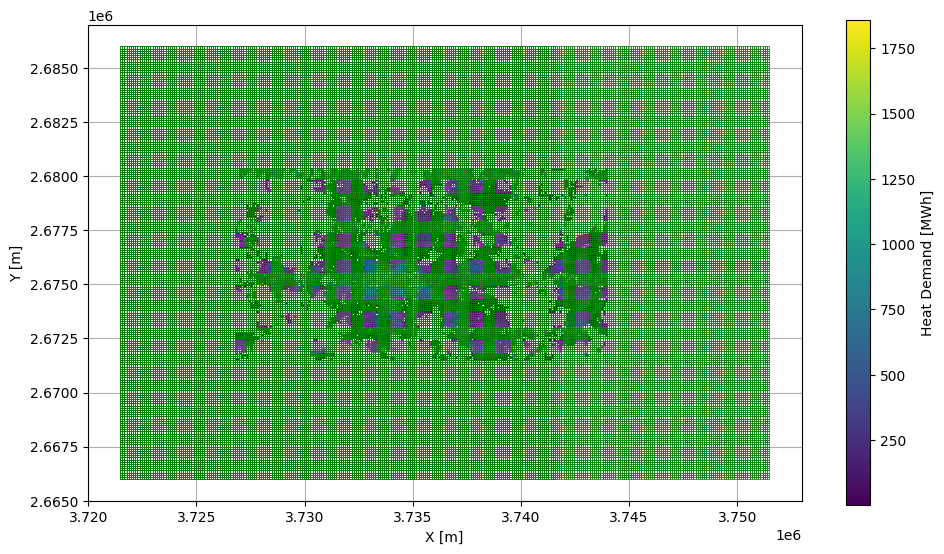

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
mask_100m_cropped.boundary.plot(ax=ax, linewidth=0.5, color='green')
raster_vectorized.plot(ax=ax, column='class', legend=True, legend_kwds={'shrink':0.5, 'label': 'Heat Demand [MWh]'})
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid()
plt.tight_layout()

## Calculate Heat Demand

With the vectorized raster and the 100m mask, we can now directly calculate the heat demand using `calculate_hd`. 

In [18]:
hd_gdf = raster_vectorized
mask_gdf = mask_100m_cropped

In [19]:
gdf_hd = processing.calculate_hd(hd_gdf, 
                                 mask_gdf, 
                                 'class')
gdf_hd 

,HD,geometry
0,111.620963,"POLYGON ((3726770.877 2671399.353, 3726870.877..."
1,142.831789,"POLYGON ((3726770.877 2671499.353, 3726870.877..."
2,20.780601,"POLYGON ((3726770.877 2671699.353, 3726870.877..."
3,16.787779,"POLYGON ((3726770.877 2671799.353, 3726870.877..."
4,36.917489,"POLYGON ((3726770.877 2671899.353, 3726870.877..."
...,...,...
9773,96.224149,"POLYGON ((3743970.877 2679899.353, 3744070.877..."
9774,117.341054,"POLYGON ((3743970.877 2679999.353, 3744070.877..."
9775,68.516312,"POLYGON ((3743970.877 2680099.353, 3744070.877..."
9776,15.080595,"POLYGON ((3743970.877 2680199.353, 3744070.877..."


<Axes: >

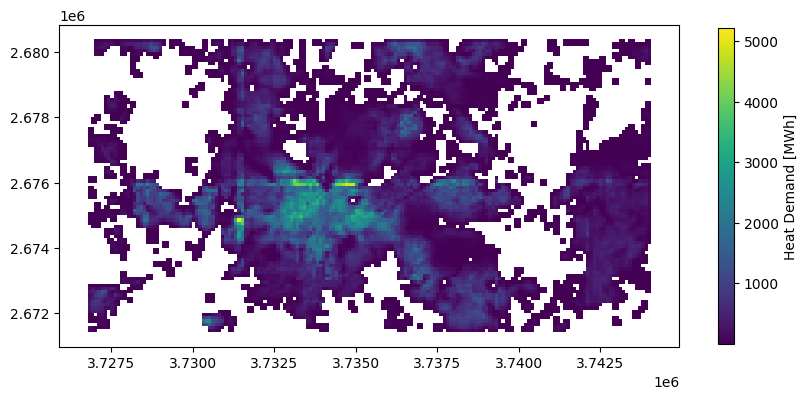

In [20]:
fig, ax = plt.subplots(1, figsize=(10,10))

gdf_hd.plot(column='HD', ax=ax, legend=True, legend_kwds={'shrink':0.41, 'label': 'Heat Demand [MWh]'})

## Rasterizing Vector Data

The vector data will be rasterized and saved to file.

In [21]:
processing.rasterize_gdf_hd(gdf_hd, 
                     path_out='../../../test/data/Data_Type_I.tif',
                     crs = 'EPSG:3034', 
                     xsize = 100,
                     ysize = 100)

## Opening and plotting raster
The final raster can now be opened and plotted. 

In [22]:
raster = rasterio.open('../../../test/data/Data_Type_I.tif')

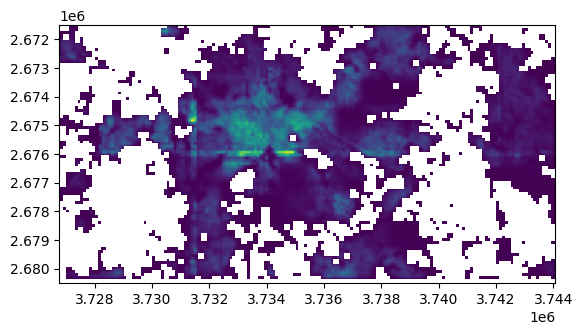

<Axes: >

In [23]:
show(raster)